In [12]:
# Importing the data
import kagglehub

# Downloading the dataset
path = kagglehub.dataset_download("kausthubkannan/5-flower-types-classification-dataset")
print('Path to the dataset :', path)

100%|██████████| 242M/242M [00:11<00:00, 21.5MB/s]

Extracting files...


Path to the dataset : /root/.cache/kagglehub/datasets/kausthubkannan/5-flower-types-classification-dataset/versions/1


In [13]:
# Importing important libraries
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import numpy as np
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings('ignore')

In [16]:
# Step 1 : Dataset path
base_dir = "/root/.cache/kagglehub/datasets/kausthubkannan/5-flower-types-classification-dataset/versions/1"

In [17]:
# Step 2 : Data Generators
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)

# Update base_dir to point to the directory containing the class subdirectories
# Assuming the structure is base_dir/flower_images/class_name/image.jpg
train_gen = train_datagen.flow_from_directory(os.path.join(base_dir, 'flower_images'),
                                              target_size = (128, 128),
                                              batch_size = 32,
                                              class_mode = 'categorical',
                                              subset = 'training',
                                              shuffle = True)

val_gen = train_datagen.flow_from_directory(os.path.join(base_dir, 'flower_images'),
                                              target_size = (128, 128),
                                              batch_size = 32,
                                              class_mode = 'categorical',
                                              subset = 'validation',
                                              shuffle = True)
print("Classes :", list(train_gen.class_indices.keys()))

Found 4000 images belonging to 5 classes.
Found 1000 images belonging to 5 classes.
Classes : ['Lilly', 'Lotus', 'Orchid', 'Sunflower', 'Tulip']


In [18]:
# Step 3 : Show sample dataset images
def show_sample_images(generator):
  x, y = next(generator)
  plt.figure(figsize = (9, 3))
  for i in range(5):
    plt.subplot(1, 5, i+1)
    plt.imshow(x[i])
    plt.title(list(generator.class_indices.keys())[np.argmax(y[i])])
  plt.show()

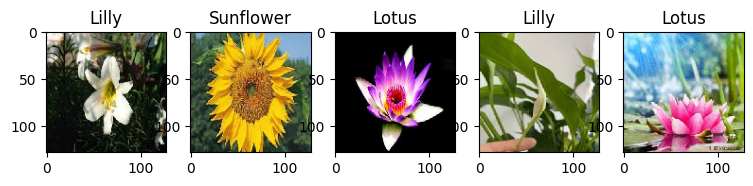

In [10]:
# Driver Code
show_sample_images(train_gen)

In [19]:
# Step 4 : Augmenting the images
aug_datagen_display = ImageDataGenerator(
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest'
)

In [20]:
# Function to get a random image path from a directory
def get_random_image_path(base_path):
  class_dirs = [d for d in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, d))]
  random_class_dir = random.choice(class_dirs)
  random_class_path = os.path.join(base_path, random_class_dir)
  images = []
  for root, dirs, files in os.walk(random_class_path):
    for file in files:
      if file.lower().endswith(('.png', '.jpg', '.jpeg')):
        images.append(os.path.join(root, file))
  if not images:
      raise IndexError("No image files found in the directory structure.")
  random_image_name = random.choice(images)
  return os.path.join(random_class_path, random_image_name)

In [21]:
# Driver Code
sample_image_path = get_random_image_path(base_dir)
print("Sample Image Path :", sample_image_path)

Sample Image Path : /root/.cache/kagglehub/datasets/kausthubkannan/5-flower-types-classification-dataset/versions/1/flower_images/Orchid/e41fac39b5.jpg


In [22]:
# Reshaping the image
img = load_img(sample_image_path, target_size = (128, 128))
x = img_to_array(img)
x = x.reshape((1,) + x.shape) # Reshape it to (1, 128, 128, 3)

In [23]:
# Function for augmenting the image
def show_augmented_images_with_originals(img_array, datagen, num_images = 4):
  plt.figure(figsize = (15, 5))

  # Display the actual image
  plt.subplot(1, num_images + 1, 1)
  # The original image is in 0-255 range, so we normalize for plotting
  plt.imshow(img_array.reshape(128, 128, 3) / 255.0)
  plt.title("Original Image")
  plt.axis('off')

  # Display the augmented images
  i = 2
  for batch in datagen.flow(img_array, batch_size = 1):
    plt.subplot(1, num_images + 1, i)
    # The augmented image is also in 0-255 range, so we will normalize it as well
    plt.imshow(batch[0] / 255.0)
    plt.title(f"Augmented Image {i-1}")
    plt.axis('off')
    i += 1
    if i > num_images + 1:
      break

  plt.suptitle('Sample Original vs Augmented Images')
  plt.show()

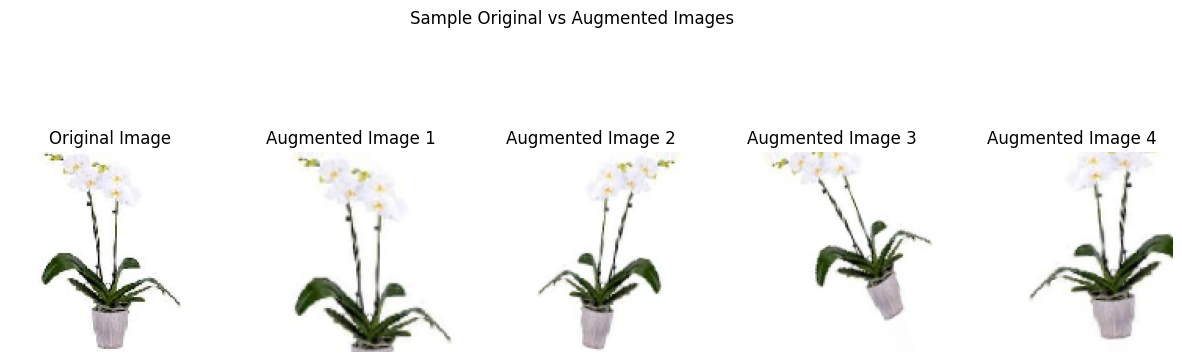

In [24]:
# Driver Code
show_augmented_images_with_originals(x, aug_datagen_display)

In [25]:
# Step 5 : Model Builder Function
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def build_cnn_model(num_filters = 32, num_hidden = 1, neurons = 64, dropout_rate = 0.3):
  model = Sequential()
  model.add(Conv2D(num_filters, (3, 3), activation = 'relu', input_shape = (128, 128, 3)))
  model.add(MaxPooling2D((2, 2)))
  model.add(Conv2D(num_filters * 2, (3, 3), activation = 'relu'))
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  for _ in range(num_hidden):
    model.add(Dense(neurons, activation = 'relu'))
    model.add(Dropout(dropout_rate))

  model.add(Dense(len(train_gen.class_indices), activation = 'softmax'))
  model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
  return model

In [26]:
# Step 6 : Train multiple models
from tensorflow.keras.callbacks import EarlyStopping

configs = [
    {"num_filters" : 32, "num_hidden" : 1, "neurons" : 64, "dropout_rate" : 0.5}, # Increased dropout
    {"num_filters" : 32, "num_hidden" : 2, "neurons" : 128, "dropout_rate" : 0.5}, # Increased dropout
    {"num_filters" : 64, "num_hidden" : 3, "neurons" : 256, "dropout_rate" : 0.7}, # Increased dropout
]

early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

results = []
for cfg in configs:
  model = build_cnn_model(**cfg)
  history = model.fit(train_gen, epochs = 10, validation_data = val_gen,
                      callbacks = [early_stop], verbose = 1)
  val_acc = max(history.history['val_accuracy'])
  results.append((cfg, val_acc))

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 133ms/step - accuracy: 0.3215 - loss: 1.8752 - val_accuracy: 0.5700 - val_loss: 1.1039
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 116ms/step - accuracy: 0.5676 - loss: 1.1033 - val_accuracy: 0.6640 - val_loss: 0.9350
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.6569 - loss: 0.8994 - val_accuracy: 0.7170 - val_loss: 0.8191
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 121ms/step - accuracy: 0.7346 - loss: 0.7382 - val_accuracy: 0.7240 - val_loss: 0.7350
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 123ms/step - accuracy: 0.8046 - loss: 0.5329 - val_accuracy: 0.7880 - val_loss: 0.6567
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 118ms/step - accuracy: 0.8536 - loss: 0.4264 - val_accuracy: 0.7980 - val_loss: 0.6797
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 17s 137ms/step - accuracy: 0.8760 - loss: 0.3490 - val_accuracy: 0.8150 - val_loss: 0.7064
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 119ms/step - accuracy: 0.8991 - loss: 0

In [ ]:
'''
All the 3 models with the given configuration are overfitting.
Now, when the model is overfitting, we are try for the following things ->

(1) Training Level Changes ->
Early Stopping with lower patience / monitoring "val_accuracy" & "val_loss".
Check for class imbalance and sort it out if needed.
Increase dropout percentage
Add L2 Regularization Layer

(2) Data Level Changes ->
Add more data by data augmentation & having wider range of parameters for data augmentation.
Cross Validation (k-Fold Cross Validation)
Add noise to the data
'''

In [27]:
# printing the best configuration
print('\nFinal Results')
if results: # Added check for empty results
  for cfg, acc in results:
    print(f"Config {cfg} -> Best Val Accuracy : {acc:.3f}")
else:
  print("No results to display.")


Final Results
Config {'num_filters': 32, 'num_hidden': 1, 'neurons': 64, 'dropout_rate': 0.5} -> Best Val Accuracy : 0.825
Config {'num_filters': 32, 'num_hidden': 2, 'neurons': 128, 'dropout_rate': 0.5} -> Best Val Accuracy : 0.819
Config {'num_filters': 64, 'num_hidden': 3, 'neurons': 256, 'dropout_rate': 0.7} -> Best Val Accuracy : 0.431


In [28]:
# Importing a pretrained model
base_model = tf.keras.applications.VGG16(include_top = False, input_shape = (128, 128, 3), weights = 'imagenet')
base_model.trainable = False

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [29]:
# Creating the model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(len(train_gen.class_indices), activation = 'softmax'))

In [30]:
# Compiling the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [31]:
# Early Stopping
early_stop = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

In [32]:
# Fitting the data
history = model.fit(train_gen, epochs = 10, validation_data = val_gen,
                    callbacks = [early_stop], verbose = 1)

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 32s 188ms/step - accuracy: 0.5077 - loss: 1.3223 - val_accuracy: 0.8050 - val_loss: 0.6138
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.7534 - loss: 0.6703 - val_accuracy: 0.8260 - val_loss: 0.5051
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 16s 130ms/step - accuracy: 0.8012 - loss: 0.5270 - val_accuracy: 0.8340 - val_loss: 0.5134
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 125ms/step - accuracy: 0.8449 - loss: 0.4418 - val_accuracy: 0.8750 - val_loss: 0.4167
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.8903 - loss: 0.3176 - val_accuracy: 0.8770 - val_loss: 0.3917
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 143ms/step - accuracy: 0.9051 - loss: 0.2705 - val_accuracy: 0.8870 - val_loss: 0.3513
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 18s 142ms/step - accuracy: 0.9184 - loss: 0.2504 - val_accuracy: 0.8920 - val_loss: 0.3633
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.9284 - loss: 0

# As you can see the above model is not overfitted.